In [66]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [67]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [68]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [69]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [70]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

## Features

1. (Good)

In [73]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':')
    res_list = []

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') 
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) 
        res_list.append(np.nansum(df_rel['gte_50runs']))
        
    return np.nansum(res_list)

In [74]:
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

train_data = train_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

100%|██████████| 271/271 [00:03<00:00, 81.39it/s]


slope: 0.6 / 0.39 =  1.53


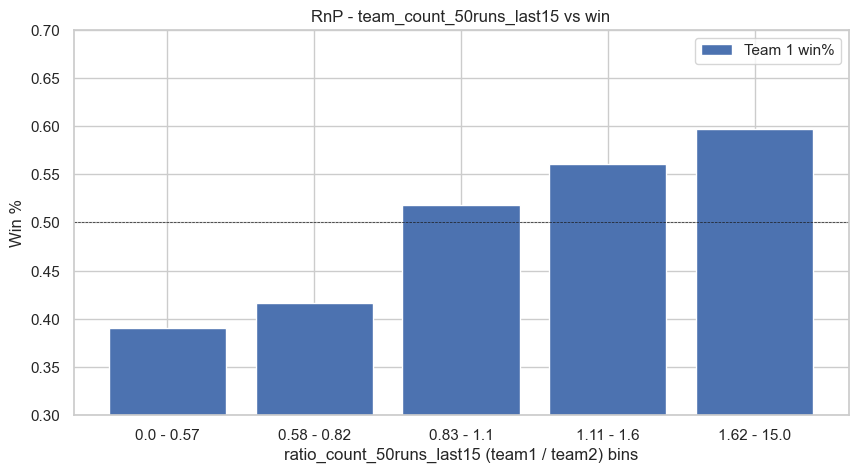

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931


In [75]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


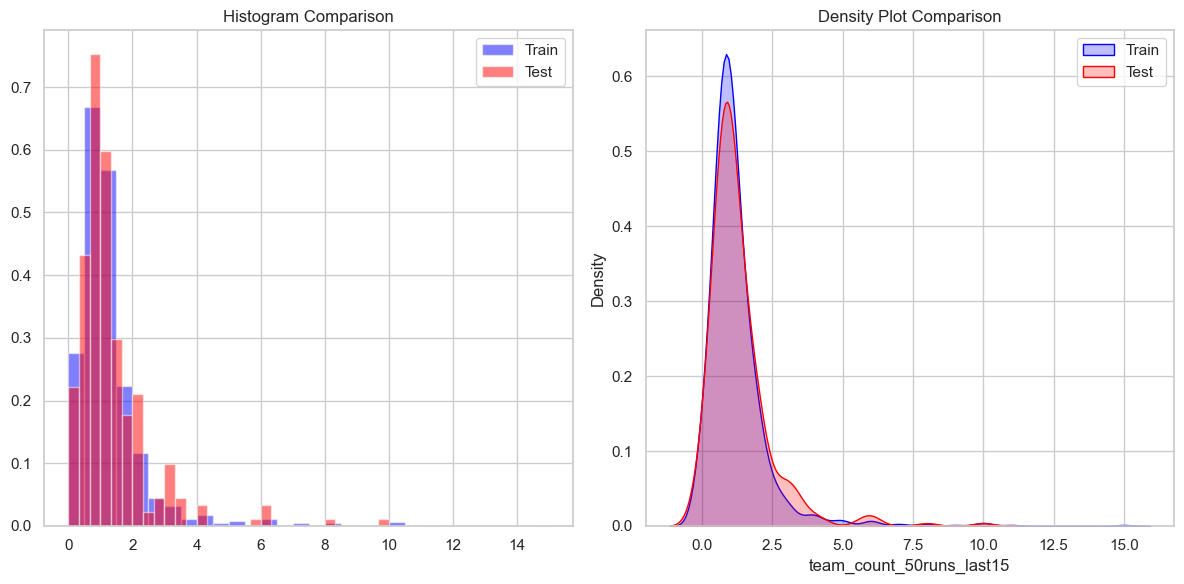

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000


In [76]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

2

In [77]:
def average_runs_per_match(player_list, date, n):
    player_list = player_list.split(':')

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        if not df_rel.empty:
            return df_rel['runs'].mean()
        else:
            return np.nan

In [78]:
train_data['team1_avg_runs'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_avg_runs'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_runs', 'team2_avg_runs', 'team_avg_runs')

train_data = train_data.drop(columns=['team1_avg_runs', 'team2_avg_runs'])

test_data['team1_avg_runs'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_runs'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_runs', 'team2_avg_runs', 'team_avg_runs')

test_data = test_data.drop(columns=['team1_avg_runs', 'team2_avg_runs'])

100%|██████████| 271/271 [00:00<00:00, 974.50it/s]


slope: 0.53 / 0.47 =  1.13


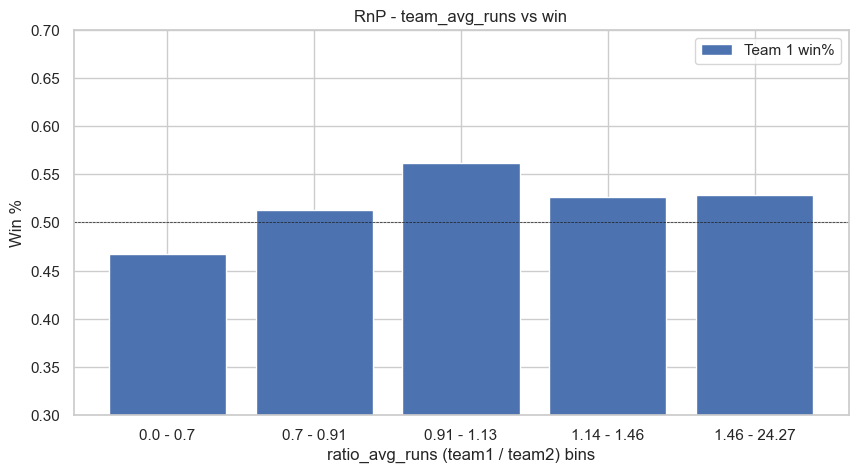

Correlation between team_avg_runs and winner_01 is: -0.013392074603331094


In [79]:
createRnP(train_data, 'team_avg_runs')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


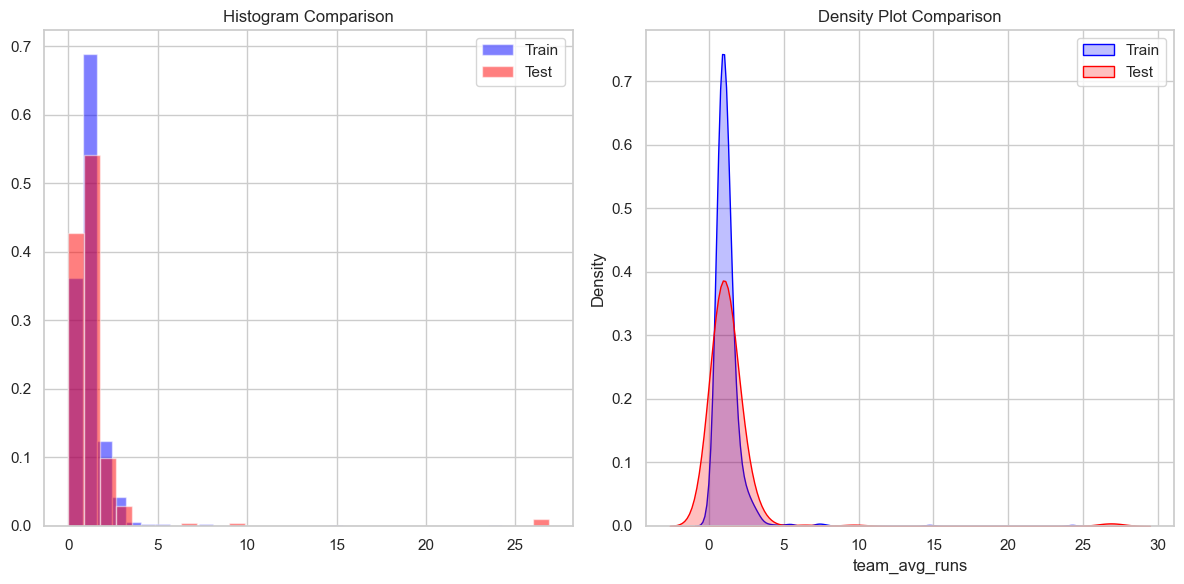

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   772.000000  225.000000
mean      1.210766    1.400921
std       1.207829    2.572217
min       0.000000    0.000000
25%       0.766801    0.743671
50%       1.019051    0.993865
75%       1.328620    1.349020
max      24.266667   26.857143


In [80]:
check_distribution_match(train_data['team_avg_runs'], test_data['team_avg_runs'])

3.

In [81]:
def strike_rate_improvement(player_list, date, n):
    """
    Evaluates the mean change in strike rate for a list of players over the last n matches compared to the previous n matches.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each period
    :return: Mean change in strike rate for the list of players
    """
    player_list = player_list.split(':')
    total_improvement = 0
    count = 0

    for player in player_list:
        last_2n_matches = giveLastNgamesPlayer(player_id=player, date=date, n = 2*n, bat_or_bowl='bat')
        if not last_2n_matches.empty:
            recent_period = last_2n_matches.head(n)
            previous_period = last_2n_matches.tail(n)

            recent_sr_avg = recent_period['strike_rate'].mean() if not recent_period.empty else 0
            previous_sr_avg = previous_period['strike_rate'].mean() if not previous_period.empty else 0

            total_improvement += recent_sr_avg - previous_sr_avg
            count += 1

    return total_improvement / count if count > 0 else 0

In [82]:
train_data['team1_strike_rate_improvement'] = train_data.progress_apply(lambda x: \
            strike_rate_improvement(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_strike_rate_improvement'] = train_data.progress_apply(lambda x: \
            strike_rate_improvement(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_strike_rate_improvement', 'team2_strike_rate_improvement', 'team_strike_rate_improvement')

train_data = train_data.drop(columns=['team1_strike_rate_improvement', 'team2_strike_rate_improvement'])

test_data['team1_strike_rate_improvement'] = test_data.progress_apply(lambda x: \
            strike_rate_improvement(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_strike_rate_improvement'] = test_data.progress_apply(lambda x: \
            strike_rate_improvement(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_strike_rate_improvement', 'team2_strike_rate_improvement', 'team_strike_rate_improvement')

test_data = test_data.drop(columns=['team1_strike_rate_improvement', 'team2_strike_rate_improvement'])

100%|██████████| 271/271 [00:03<00:00, 87.88it/s]


slope: 0.56 / 0.5 =  1.12


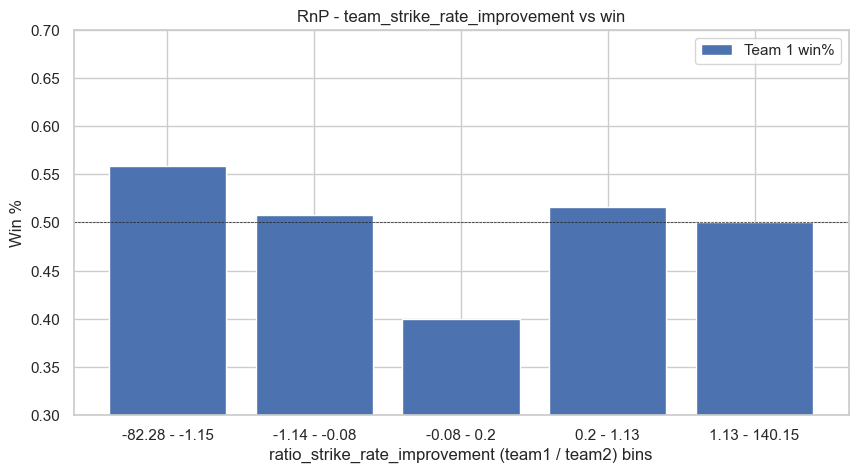

Correlation between team_strike_rate_improvement and winner_01 is: 0.018136541456056147


In [83]:
createRnP(train_data, 'team_strike_rate_improvement')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


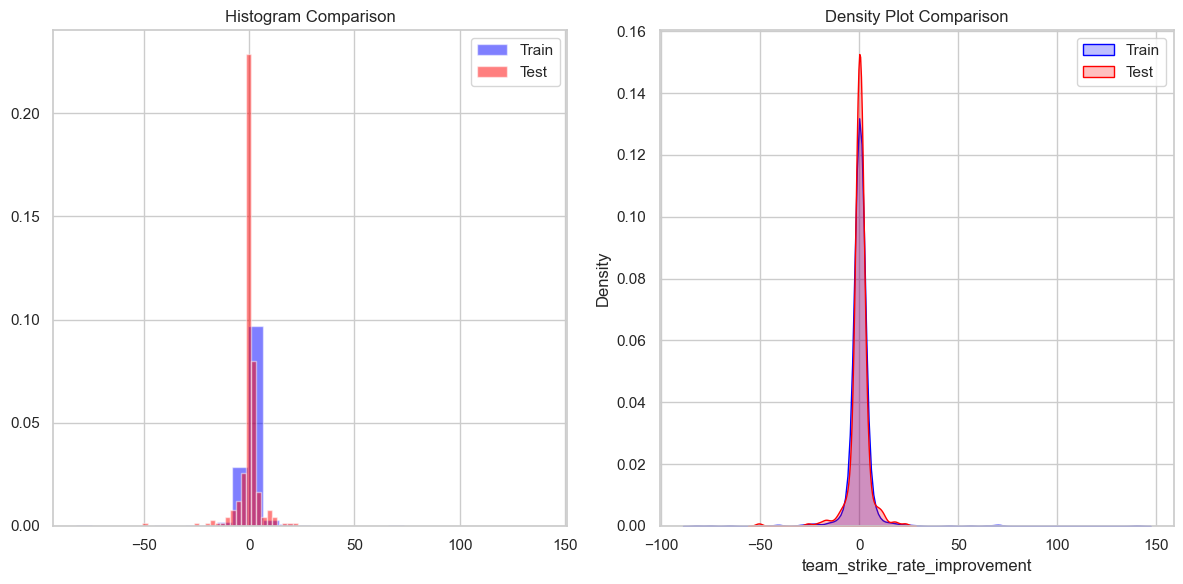

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   945.000000  270.000000
mean      0.052179   -0.187067
std       9.031104    5.518020
min     -82.275074  -50.850798
25%      -0.682478   -0.930907
50%       0.000000    0.000000
75%       0.854261    1.019341
max     140.146415   22.997868


In [84]:
check_distribution_match(train_data['team_strike_rate_improvement'], test_data['team_strike_rate_improvement'])

4. (Check)

In [87]:
def match_impact_score(player_list, date, n):
    player_list = player_list.split(':')
    total_impact_score = 0
    count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            avg_runs = player_matches['runs'].mean()
            avg_strike_rate = player_matches['strike_rate'].mean()
            top_scorer_count = sum(player_matches['runs'] == player_matches.groupby('match id')['runs'].transform('max'))

            impact_score = (avg_runs * avg_strike_rate * top_scorer_count) / 100
            total_impact_score += impact_score
            count += 1

    return total_impact_score / count if count > 0 else 0

In [88]:
train_data['team1_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

train_data = train_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

test_data['team1_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

test_data = test_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

100%|██████████| 271/271 [00:03<00:00, 77.68it/s]


slope: 0.64 / 0.36 =  1.78


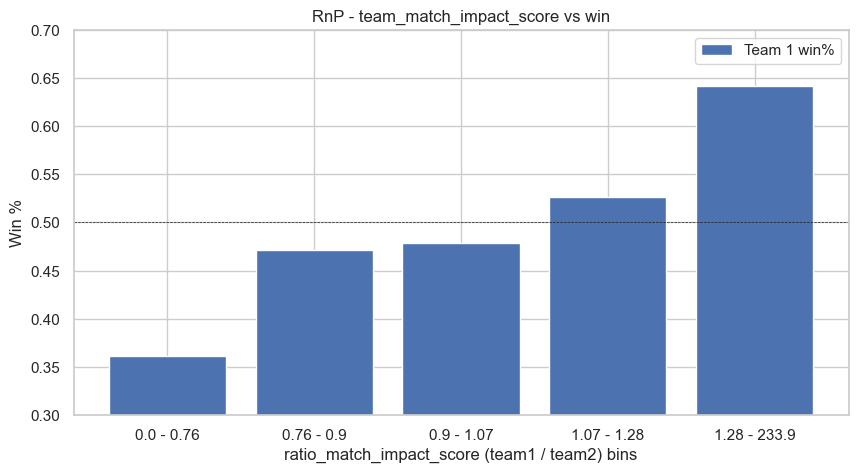

Correlation between team_match_impact_score and winner_01 is: -0.059264563222164945


In [89]:
createRnP(train_data, 'team_match_impact_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


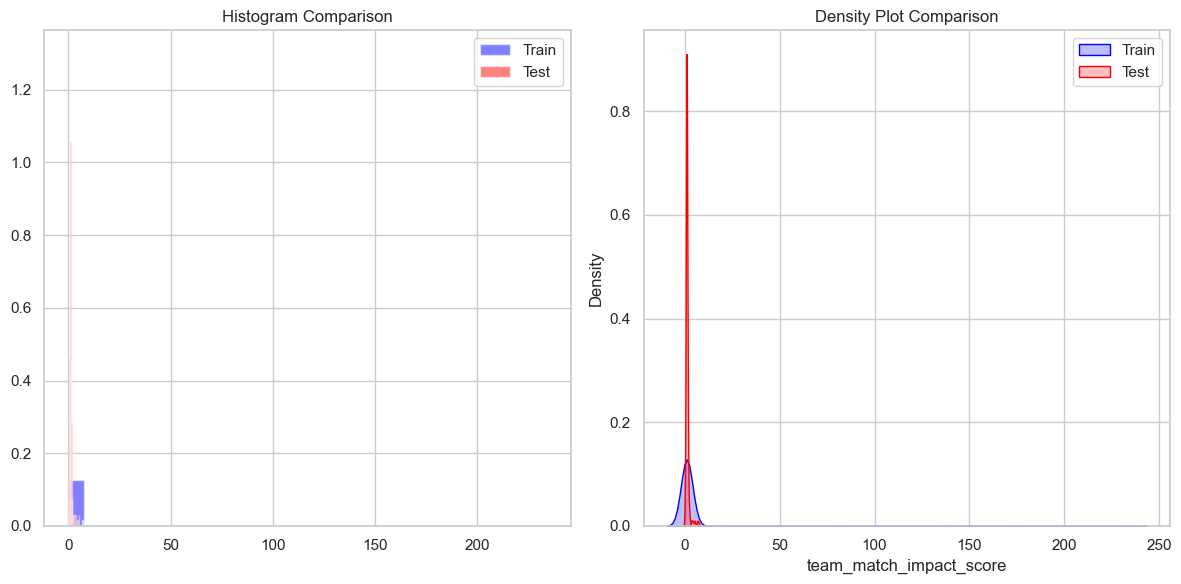

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   945.000000  270.000000
mean      2.036078    1.163776
std      11.900496    0.883064
min       0.000000    0.000000
25%       0.790835    0.811949
50%       0.989617    0.987300
75%       1.217684    1.230643
max     233.897878    7.362204


In [90]:
check_distribution_match(train_data['team_match_impact_score'], test_data['team_match_impact_score'])

5. (good)

In [91]:
def average_runs_per_match(player_list, date, n):
    """
    Calculates the mean runs scored per match for a list of players over the last n matches before a given date.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Mean runs per match for the list of players
    """
    player_list = player_list.split(':')
    total_runs = 0
    games_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            total_runs += player_matches['runs'].sum()
            games_count += len(player_matches)

    return total_runs / games_count if games_count > 0 else 0

In [92]:
train_data['team1_average_runs_per_match'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_average_runs_per_match'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_runs_per_match', 'team2_average_runs_per_match', 'team_average_runs_per_match')

train_data = train_data.drop(columns=['team1_average_runs_per_match', 'team2_average_runs_per_match'])

test_data['team1_average_runs_per_match'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_average_runs_per_match'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_runs_per_match', 'team2_average_runs_per_match', 'team_average_runs_per_match')

test_data = test_data.drop(columns=['team1_average_runs_per_match', 'team2_average_runs_per_match'])

100%|██████████| 271/271 [00:02<00:00, 91.08it/s]


slope: 0.55 / 0.46 =  1.19


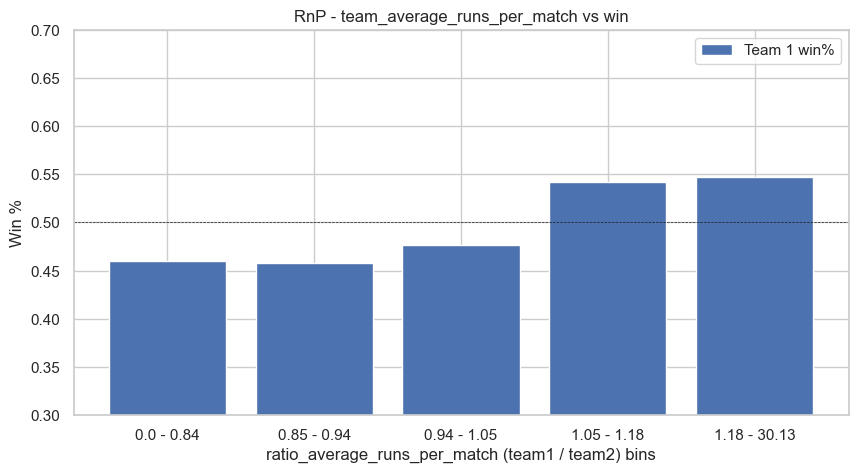

Correlation between team_average_runs_per_match and winner_01 is: -0.05775475033119512


In [93]:
createRnP(train_data, 'team_average_runs_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


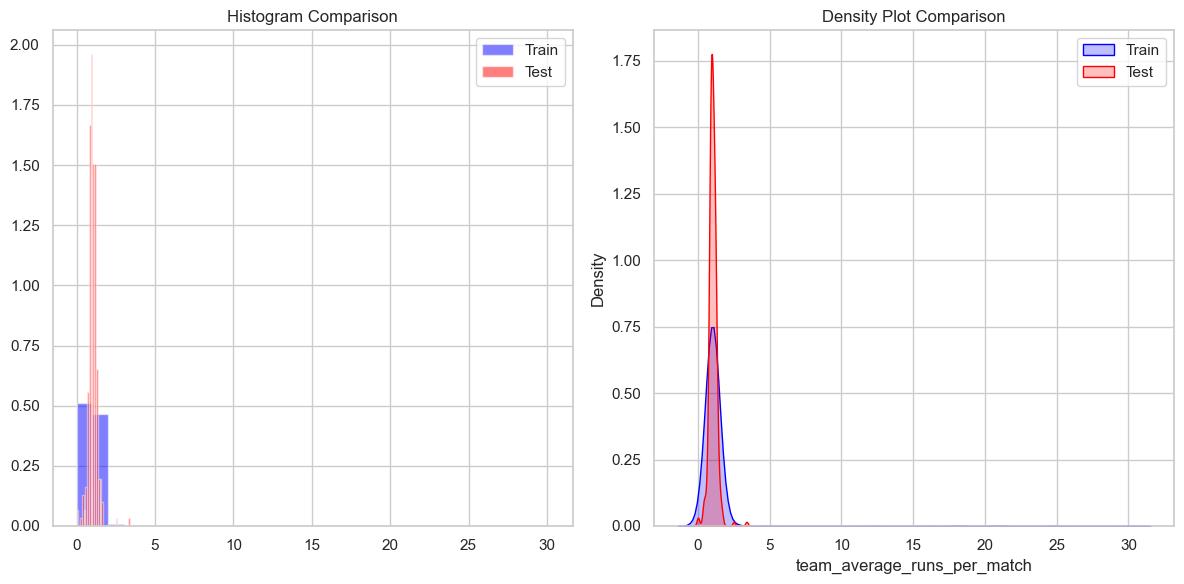

Kolmogorov-Smirnov test result: KS statistic = 0.0426, p-value = 0.8202

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.175370    1.021009
std       1.836720    0.288018
min       0.000000    0.000000
25%       0.868826    0.875353
50%       0.999033    1.008384
75%       1.142212    1.166202
max      30.133333    3.386364


In [94]:
check_distribution_match(train_data['team_average_runs_per_match'], test_data['team_average_runs_per_match'])

6.(V Good)

In [102]:
def balls_efficiency_score(player_list, date, n):
    """
    Evaluates the mean efficiency of scoring runs based on the number of balls faced for a list of players.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Mean efficiency score (total runs divided by total balls faced) for the list of players
    """
    player_list = player_list.split(':')
    total_runs = 0
    total_balls = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            total_runs += player_matches['runs'].sum()
            total_balls += player_matches['balls_faced'].sum()

    return total_runs / total_balls if total_balls > 0 else 0

In [103]:
train_data['team1_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

train_data = train_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

test_data['team1_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

test_data = test_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

100%|██████████| 271/271 [00:03<00:00, 89.94it/s]


slope: 0.62 / 0.39 =  1.59


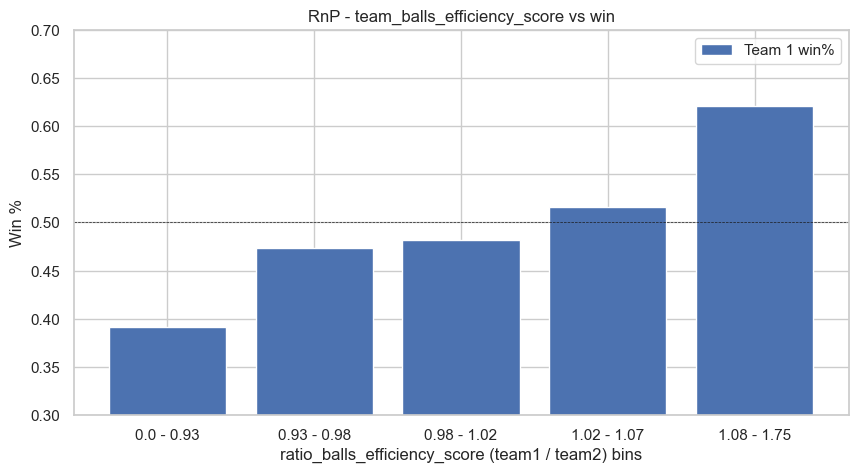

Correlation between team_balls_efficiency_score and winner_01 is: -0.15330782131214032


In [104]:
createRnP(train_data, 'team_balls_efficiency_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


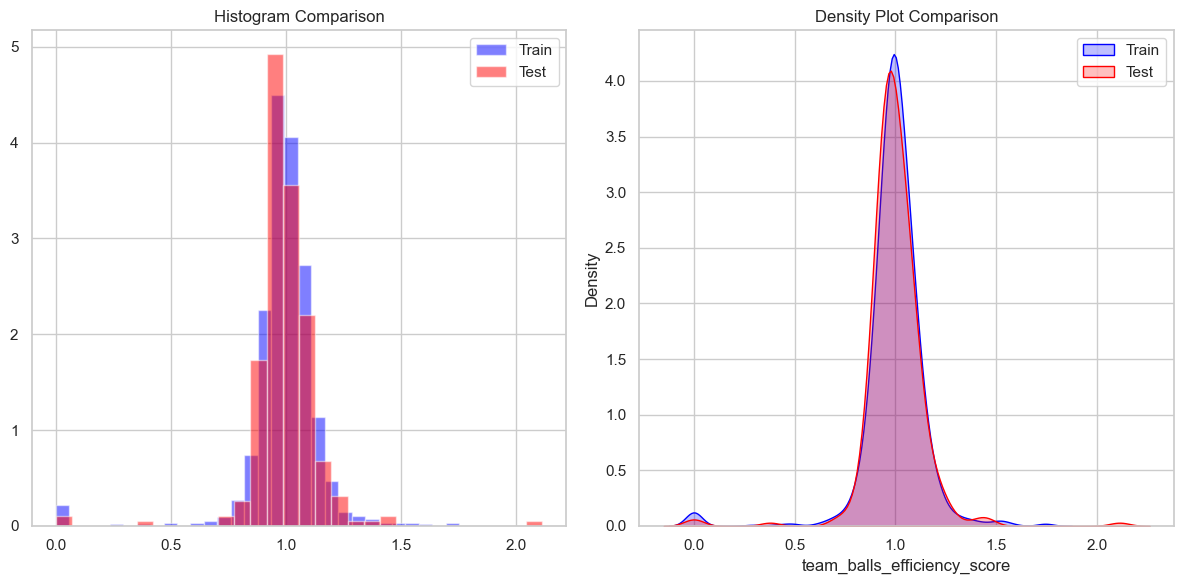

Kolmogorov-Smirnov test result: KS statistic = 0.1000, p-value = 0.0271

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.993906    0.996573
std       0.162549    0.153018
min       0.000000    0.000000
25%       0.943062    0.939211
50%       0.998334    0.981431
75%       1.058843    1.054250
max       1.752989    2.112944


In [105]:
check_distribution_match(train_data['team_balls_efficiency_score'], test_data['team_balls_efficiency_score'])

7. (Good)

In [115]:
def early_impact_score(player_list, date, n, early_overs=5):
    """
    Calculates the mean early impact score based on runs scored in the initial overs for a list of players.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :param early_overs: Number of initial overs to consider for calculating the impact
    :return: Mean early impact score for the list of players
    """
    player_list = player_list.split(':')
    total_early_runs = 0
    early_games_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        early_matches = player_matches[player_matches['over_faced_first'] <= early_overs]
        if not early_matches.empty:
            total_early_runs += early_matches['runs'].sum()
            early_games_count += len(early_matches)

    return total_early_runs / early_games_count if early_games_count > 0 else 0

In [116]:
train_data['team1_early_impact_score'] = train_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_early_impact_score'] = train_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_early_impact_score', 'team2_early_impact_score', 'team_early_impact_score')

train_data = train_data.drop(columns=['team1_early_impact_score', 'team2_early_impact_score'])

test_data['team1_early_impact_score'] = test_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_early_impact_score'] = test_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_early_impact_score', 'team2_early_impact_score', 'team_early_impact_score')

test_data = test_data.drop(columns=['team1_early_impact_score', 'team2_early_impact_score'])

100%|██████████| 271/271 [00:03<00:00, 85.05it/s]


slope: 0.53 / 0.41 =  1.29


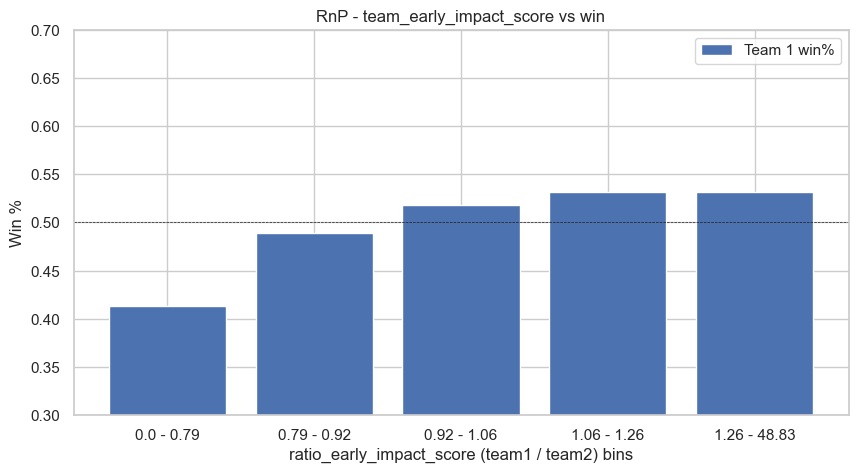

Correlation between team_early_impact_score and winner_01 is: -0.004679077475574761


In [117]:
createRnP(train_data, 'team_early_impact_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


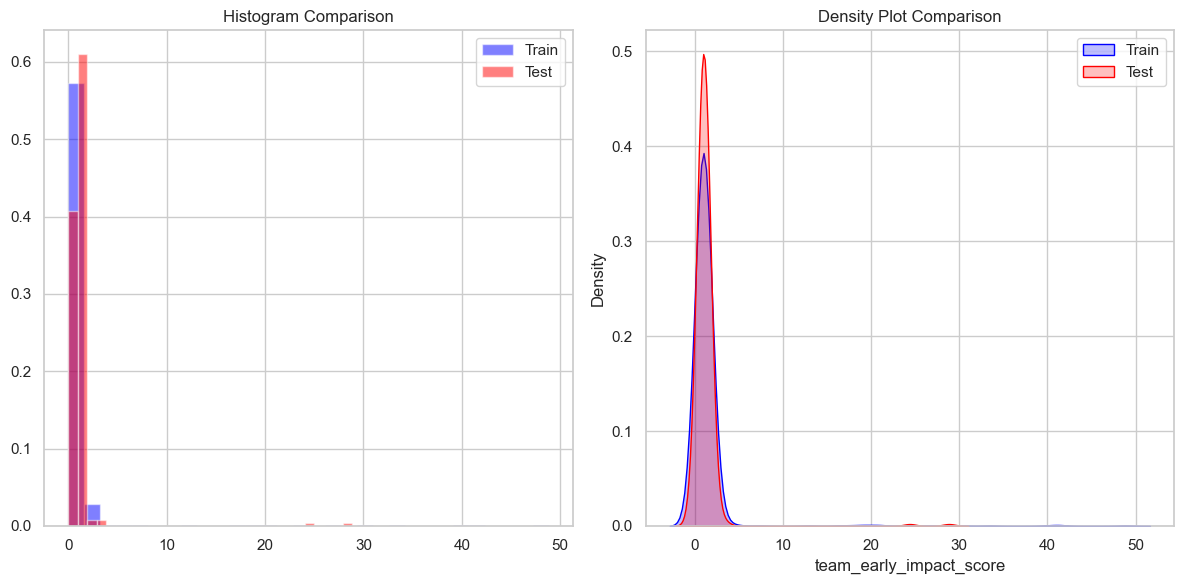

Kolmogorov-Smirnov test result: KS statistic = 0.0846, p-value = 0.0920

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.485022    1.235742
std       3.682111    2.233260
min       0.000000    0.000000
25%       0.830783    0.851305
50%       0.987384    1.023445
75%       1.210242    1.207323
max      48.833333   28.846154


In [118]:
check_distribution_match(train_data['team_early_impact_score'], test_data['team_early_impact_score'])

8. (Good/Check)

In [142]:
def boundary_efficiency_score(player_list, date, n):
    """
    Measures the team's efficiency in scoring from boundaries (fours) relative to the total runs scored.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Boundary efficiency score as a percentage
    """
    player_list = player_list.split(':')
    total_runs = 0
    runs_from_fours = 0
    runs_from_sixes = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_runs += player_matches['runs'].sum()
        runs_from_fours += player_matches['Fours'].sum() * 4
        runs_from_sixes += player_matches['Sixes'].sum() * 6

    return (runs_from_fours+runs_from_sixes / total_runs) * 100 if total_runs > 0 else 0

In [143]:
train_data['team1_boundary_efficiency_score'] = train_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_boundary_efficiency_score'] = train_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_boundary_efficiency_score', 'team2_boundary_efficiency_score', 'team_boundary_efficiency_score')

train_data = train_data.drop(columns=['team1_boundary_efficiency_score', 'team2_boundary_efficiency_score'])

test_data['team1_boundary_efficiency_score'] = test_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_boundary_efficiency_score'] = test_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_boundary_efficiency_score', 'team2_boundary_efficiency_score', 'team_boundary_efficiency_score')

test_data = test_data.drop(columns=['team1_boundary_efficiency_score', 'team2_boundary_efficiency_score'])

100%|██████████| 271/271 [00:03<00:00, 88.77it/s]


slope: 0.62 / 0.37 =  1.66


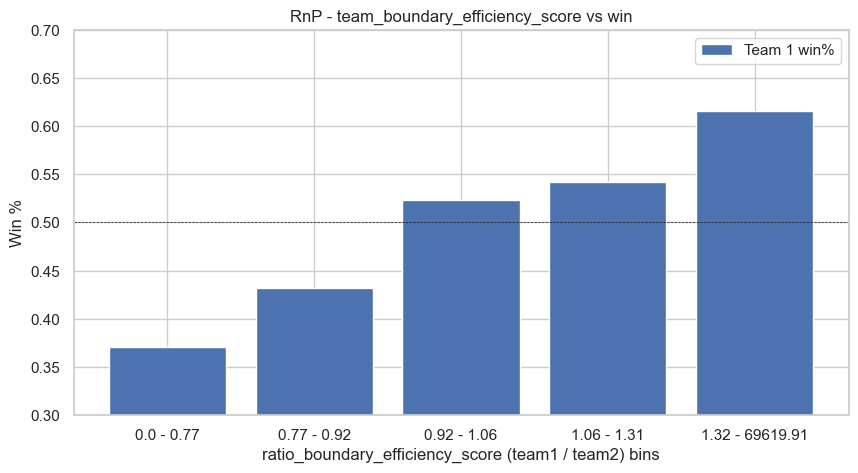

Correlation between team_boundary_efficiency_score and winner_01 is: -0.05020967518231


In [144]:
createRnP(train_data, 'team_boundary_efficiency_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


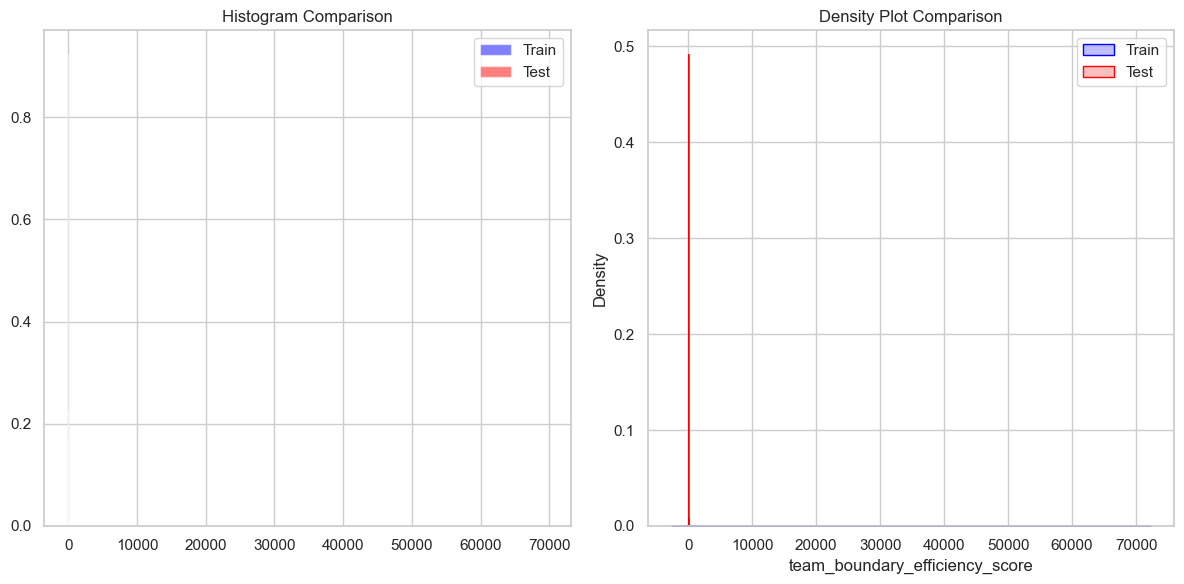

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5423

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean     249.973580    1.362262
std     3371.025234    2.076779
min        0.000000    0.000000
25%        0.814000    0.806361
50%        0.981386    0.995360
75%        1.232128    1.273554
max    69619.906687   21.459506


In [145]:
check_distribution_match(train_data['team_boundary_efficiency_score'], test_data['team_boundary_efficiency_score'])

9.

In [146]:
def inning_wise_team_performance(player_list, date, n):
    """
    Analyzes team performance across different innings, providing a single average performance score.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Single average performance score for the team based on runs and strike rate
    """
    player_list = player_list.split(':')
    total_runs = 0
    total_strike_rate = 0
    match_counts = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_runs += player_matches['runs'].sum()
        total_strike_rate += player_matches['strike_rate'].sum()
        match_counts += len(player_matches)

    # Calculate combined averages
    average_runs = total_runs / match_counts if match_counts else 0
    average_strike_rate = total_strike_rate / match_counts if match_counts else 0

    # Formulate a single metric combining these averages
    return (average_runs + average_strike_rate) / 2

In [147]:
train_data['team1_inning_wise_team_performance'] = train_data.progress_apply(lambda x: \
            inning_wise_team_performance(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_inning_wise_team_performance'] = train_data.progress_apply(lambda x: \
            inning_wise_team_performance(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_inning_wise_team_performance', 'team2_inning_wise_team_performance', 'team_inning_wise_team_performance')

train_data = train_data.drop(columns=['team1_inning_wise_team_performance', 'team2_inning_wise_team_performance'])

test_data['team1_inning_wise_team_performance'] = test_data.progress_apply(lambda x: \
            inning_wise_team_performance(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_inning_wise_team_performance'] = test_data.progress_apply(lambda x: \
            inning_wise_team_performance(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_inning_wise_team_performance', 'team2_inning_wise_team_performance', 'team_inning_wise_team_performance')

test_data = test_data.drop(columns=['team1_inning_wise_team_performance', 'team2_inning_wise_team_performance'])

100%|██████████| 271/271 [00:03<00:00, 89.19it/s]


slope: 0.62 / 0.39 =  1.59


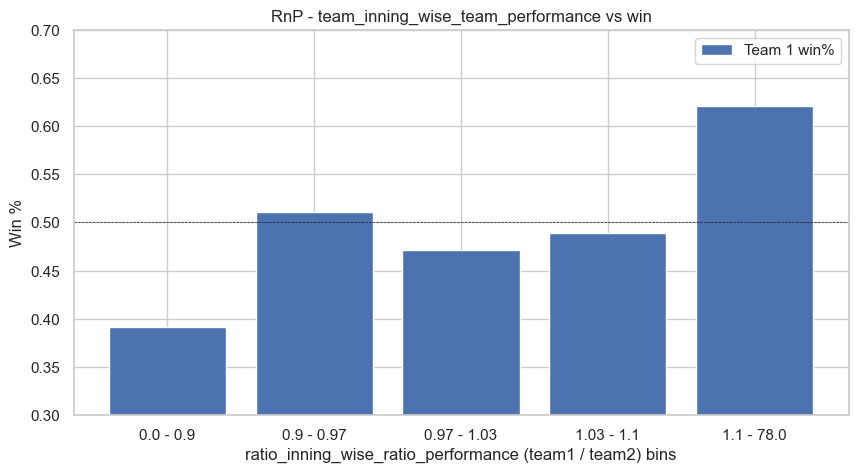

Correlation between team_inning_wise_team_performance and winner_01 is: -0.04877374628289134


In [148]:
createRnP(train_data, 'team_inning_wise_team_performance')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


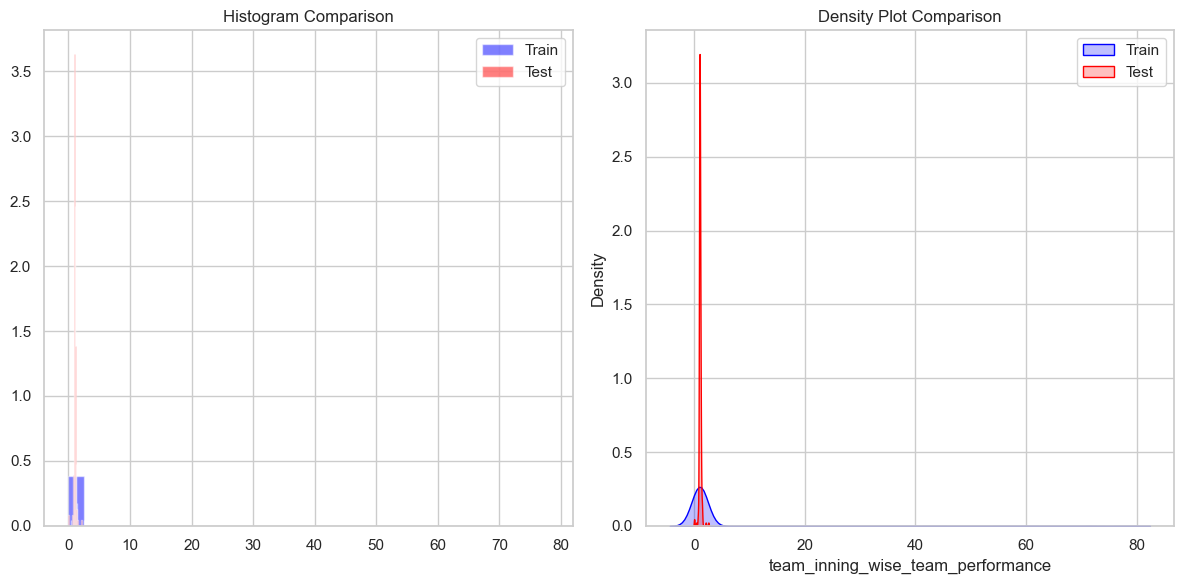

Kolmogorov-Smirnov test result: KS statistic = 0.0559, p-value = 0.5043

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.522617    1.010287
std       5.796478    0.193105
min       0.000000    0.000000
25%       0.924609    0.931087
50%       0.996096    0.988255
75%       1.081620    1.075543
max      78.002667    2.560841


In [149]:
check_distribution_match(train_data['team_inning_wise_team_performance'], test_data['team_inning_wise_team_performance'])

10.

In [150]:
def team_average_start(player_list, date, n):
    """
    Calculates the average start over for the team based on the first over faced by the batsmen.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Average first over faced by the team
    """
    player_list = player_list.split(':')
    total_first_overs = 0
    innings_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_first_overs += player_matches['over_faced_first'].sum()
        innings_count += len(player_matches)

    return total_first_overs / innings_count if innings_count > 0 else 0


In [151]:
train_data['team1_team_average_start'] = train_data.progress_apply(lambda x: \
            team_average_start(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_average_start'] = train_data.progress_apply(lambda x: \
            team_average_start(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_average_start', 'team2_team_average_start', 'team_team_average_start')

train_data = train_data.drop(columns=['team1_team_average_start', 'team2_team_average_start'])

test_data['team1_team_average_start'] = test_data.progress_apply(lambda x: \
            team_average_start(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_average_start'] = test_data.progress_apply(lambda x: \
            team_average_start(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_average_start', 'team2_team_average_start', 'team_team_average_start')

test_data = test_data.drop(columns=['team1_team_average_start', 'team2_team_average_start'])

100%|██████████| 271/271 [00:03<00:00, 89.71it/s]


slope: 0.55 / 0.45 =  1.22


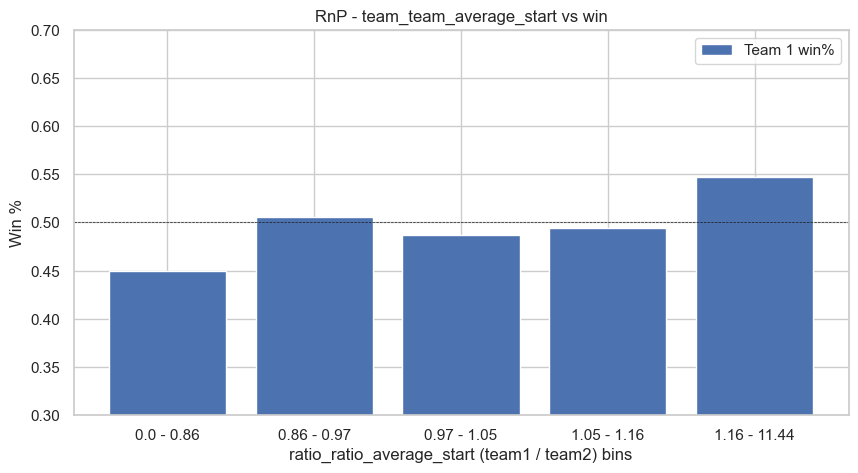

Correlation between team_team_average_start and winner_01 is: -0.049794832036775545


In [152]:
createRnP(train_data, 'team_team_average_start')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


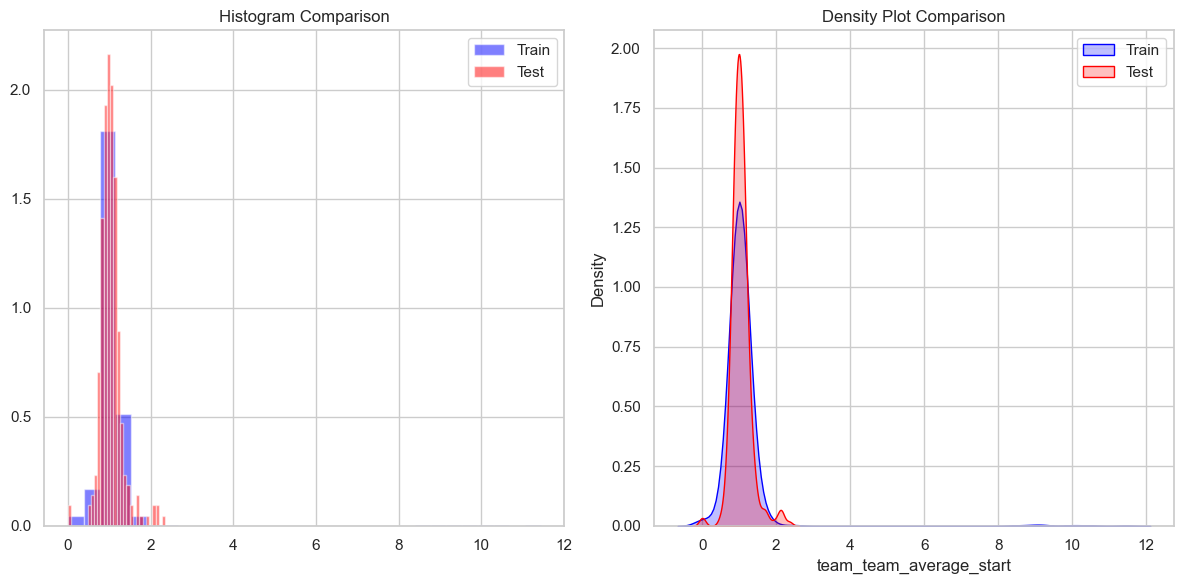

Kolmogorov-Smirnov test result: KS statistic = 0.0525, p-value = 0.5829

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.092441    1.035442
std       0.874541    0.268754
min       0.000000    0.000000
25%       0.896750    0.894576
50%       1.004259    1.004520
75%       1.134340    1.135673
max      11.443750    2.353846


In [153]:
check_distribution_match(train_data['team_team_average_start'], test_data['team_team_average_start'])

11. (Good)

In [154]:
def team_average_powerplay_score(player_list, date, n):
    """
    Calculates the team's average runs during the powerplay overs.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Average powerplay runs
    """
    player_list = player_list.split(':')
    total_powerplay_runs = 0
    powerplay_innings_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        powerplay_matches = player_matches[player_matches['over_faced_first'] <= 6]  # Considering 6 overs for T20
        total_powerplay_runs += powerplay_matches['runs'].sum()
        powerplay_innings_count += len(powerplay_matches)

    return total_powerplay_runs / powerplay_innings_count if powerplay_innings_count > 0 else 0


In [155]:
train_data['team1_team_average_powerplay_score'] = train_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_average_powerplay_score'] = train_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_average_powerplay_score', 'team2_team_average_powerplay_score', 'team_team_average_powerplay_score')

train_data = train_data.drop(columns=['team1_team_average_powerplay_score', 'team2_team_average_powerplay_score'])

test_data['team1_team_average_powerplay_score'] = test_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_average_powerplay_score'] = test_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_average_powerplay_score', 'team2_team_average_powerplay_score', 'team_team_average_powerplay_score')

test_data = test_data.drop(columns=['team1_team_average_powerplay_score', 'team2_team_average_powerplay_score'])

100%|██████████| 271/271 [00:03<00:00, 84.29it/s]


slope: 0.55 / 0.4 =  1.36


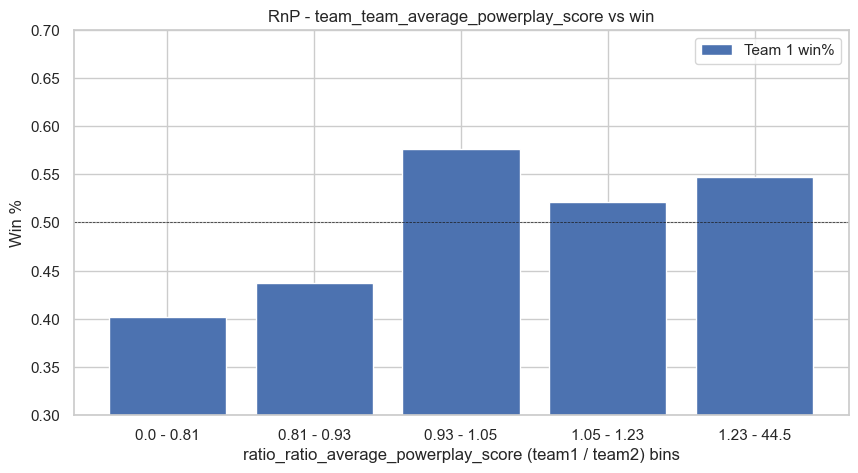

Correlation between team_team_average_powerplay_score and winner_01 is: -0.035243350866783534


In [156]:
createRnP(train_data, 'team_team_average_powerplay_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


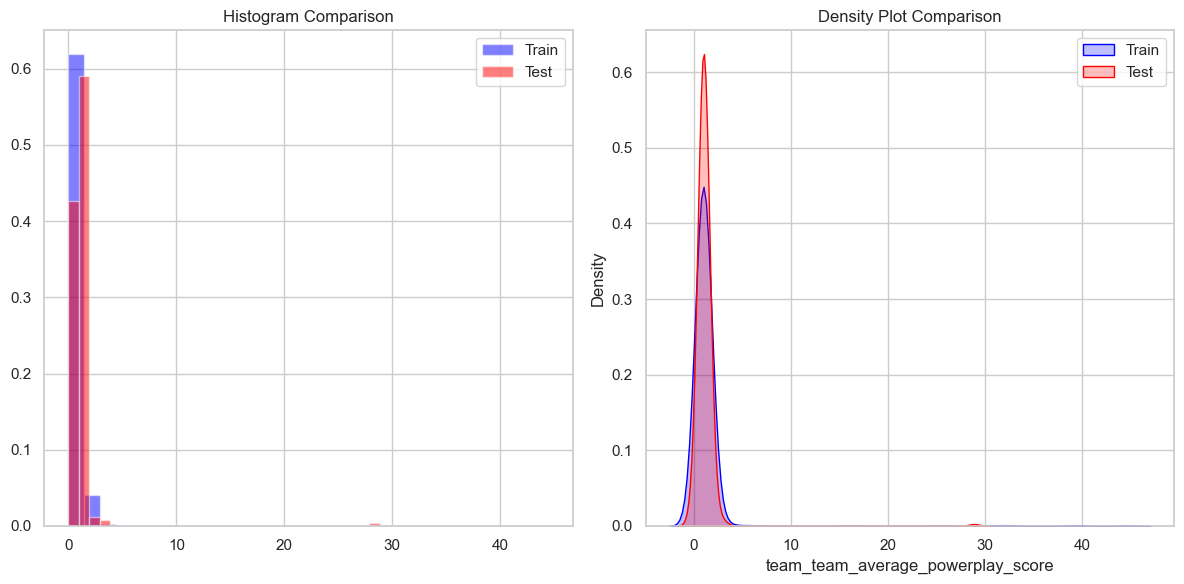

Kolmogorov-Smirnov test result: KS statistic = 0.0598, p-value = 0.4197

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.370185    1.140202
std       3.220418    1.726201
min       0.000000    0.000000
25%       0.839541    0.867860
50%       0.992005    1.011010
75%       1.182197    1.162726
max      44.500000   28.846154


In [157]:
check_distribution_match(train_data['team_team_average_powerplay_score'], test_data['team_team_average_powerplay_score'])

12.(Descent)

In [158]:
def team_boundary_percentage(player_list, date, n):
    """
    Calculates the percentage of total team runs that come from boundaries (fours and sixes).
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Boundary run percentage
    """
    player_list = player_list.split(':')
    total_runs = 0
    total_boundary_runs = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_runs += player_matches['runs'].sum()
        total_boundary_runs += (player_matches['Fours'].sum() * 4) + (player_matches['Sixes'].sum() * 6)

    return (total_boundary_runs / total_runs) * 100 if total_runs > 0 else 0


In [159]:
train_data['team1_team_boundary_percentage'] = train_data.progress_apply(lambda x: \
            team_boundary_percentage(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_boundary_percentage'] = train_data.progress_apply(lambda x: \
            team_boundary_percentage(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_boundary_percentage', 'team2_team_boundary_percentage', 'team_team_boundary_percentage')

train_data = train_data.drop(columns=['team1_team_boundary_percentage', 'team2_team_boundary_percentage'])

test_data['team1_team_boundary_percentage'] = test_data.progress_apply(lambda x: \
            team_boundary_percentage(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_boundary_percentage'] = test_data.progress_apply(lambda x: \
            team_boundary_percentage(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_boundary_percentage', 'team2_team_boundary_percentage', 'team_team_boundary_percentage')

test_data = test_data.drop(columns=['team1_team_boundary_percentage', 'team2_team_boundary_percentage'])

100%|██████████| 271/271 [00:03<00:00, 87.21it/s]


slope: 0.56 / 0.39 =  1.44


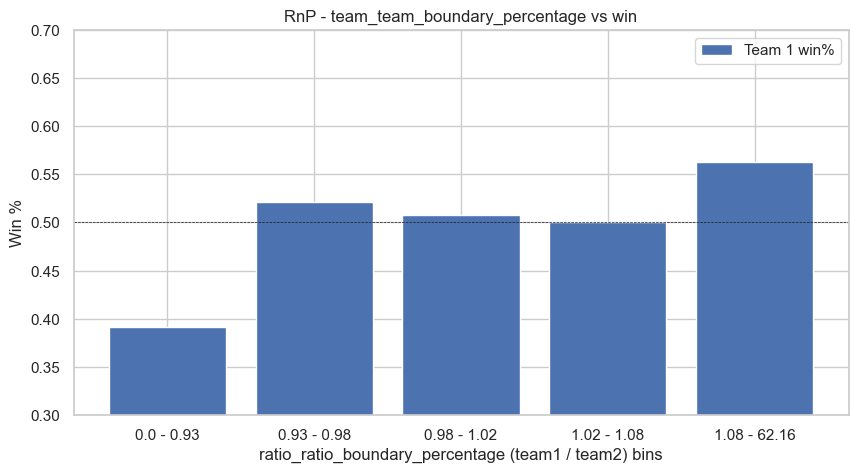

Correlation between team_team_boundary_percentage and winner_01 is: -0.04785089679472926


In [160]:
createRnP(train_data, 'team_team_boundary_percentage')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


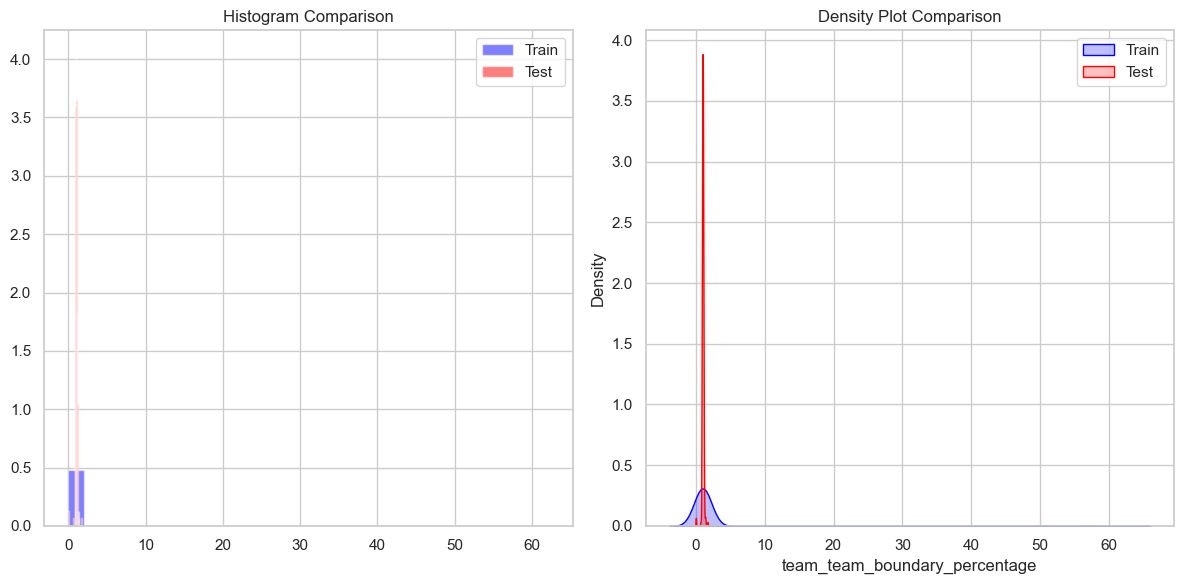

Kolmogorov-Smirnov test result: KS statistic = 0.0674, p-value = 0.2782

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.452457    0.990405
std       4.968760    0.135084
min       0.000000    0.000000
25%       0.941226    0.924692
50%       0.997819    0.996464
75%       1.066146    1.051736
max      62.162162    1.697340


In [161]:
check_distribution_match(train_data['team_team_boundary_percentage'], test_data['team_team_boundary_percentage'])

13

In [162]:
def team_average_wicket_loss_rate(player_list, date, n):
    """
    Calculates the average number of overs before the team loses a wicket.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Average number of overs before losing a wicket
    """
    player_list = player_list.split(':')
    total_overs_faced = 0
    wickets_lost = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_overs_faced += player_matches['balls_faced'].sum() / 6  # Convert balls faced to overs
        wickets_lost += player_matches[player_matches['runs'] < player_matches['runs'].max()].count()['match id']

    return total_overs_faced / wickets_lost if wickets_lost > 0 else 0

In [163]:
train_data['team1_team_average_wicket_loss_rate'] = train_data.progress_apply(lambda x: \
            team_average_wicket_loss_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_average_wicket_loss_rate'] = train_data.progress_apply(lambda x: \
            team_average_wicket_loss_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_average_wicket_loss_rate', 'team2_team_average_wicket_loss_rate', 'team_team_average_wicket_loss_rate')

train_data = train_data.drop(columns=['team1_team_average_wicket_loss_rate', 'team2_team_average_wicket_loss_rate'])

test_data['team1_team_average_wicket_loss_rate'] = test_data.progress_apply(lambda x: \
            team_average_wicket_loss_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_average_wicket_loss_rate'] = test_data.progress_apply(lambda x: \
            team_average_wicket_loss_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_average_wicket_loss_rate', 'team2_team_average_wicket_loss_rate', 'team_team_average_wicket_loss_rate')

test_data = test_data.drop(columns=['team1_team_average_wicket_loss_rate', 'team2_team_average_wicket_loss_rate'])

100%|██████████| 271/271 [00:03<00:00, 72.66it/s]


slope: 0.5 / 0.47 =  1.07


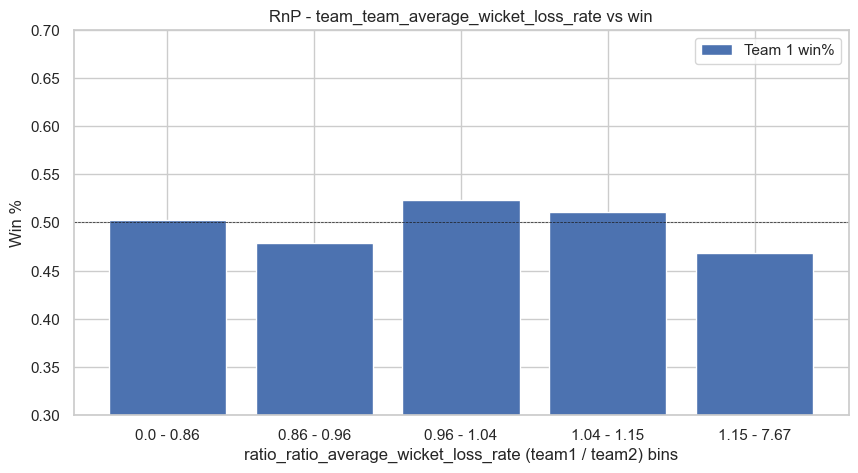

Correlation between team_team_average_wicket_loss_rate and winner_01 is: -0.035271740375404474


In [164]:
createRnP(train_data, 'team_team_average_wicket_loss_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


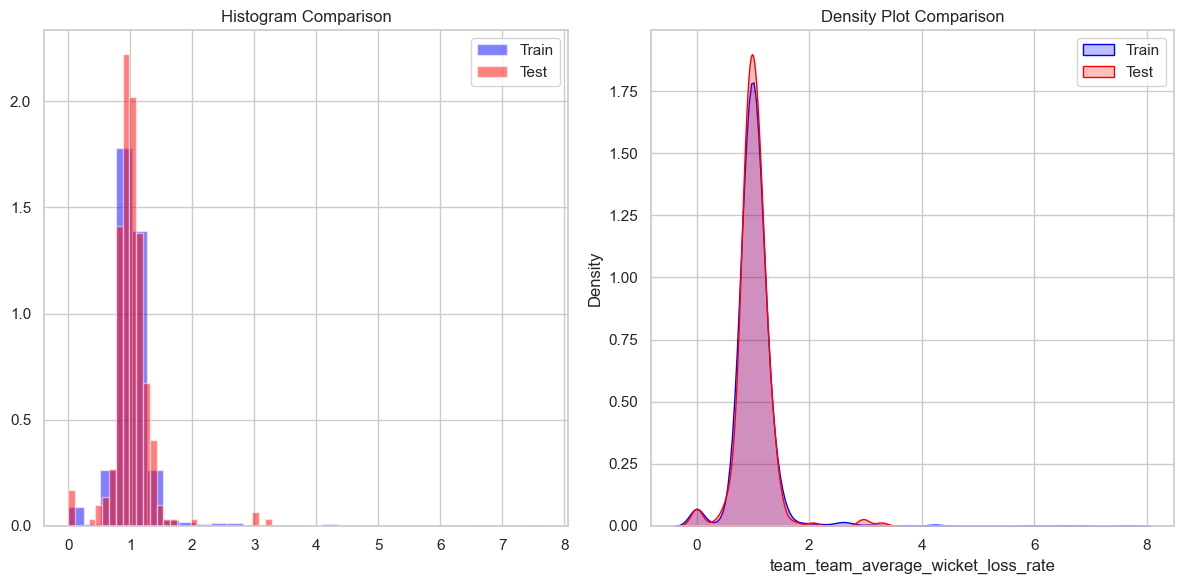

Kolmogorov-Smirnov test result: KS statistic = 0.0317, p-value = 0.9786

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.045844    1.019341
std       0.510336    0.324735
min       0.000000    0.000000
25%       0.889462    0.882821
50%       1.000625    1.013109
75%       1.120055    1.120963
max       7.666667    3.287234


In [165]:
check_distribution_match(train_data['team_team_average_wicket_loss_rate'], test_data['team_team_average_wicket_loss_rate'])

14. (Good)

In [166]:
def team_scoring_consistency(player_list, date, n):
    """
    Calculates the standard deviation of runs scored by the team, indicating scoring consistency.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Standard deviation of team scores
    """
    player_list = player_list.split(':')
    scores = []

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        scores.extend(player_matches['runs'].tolist())

    return np.std(scores) if scores else 0

In [167]:
train_data['team1_team_scoring_consistency'] = train_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_scoring_consistency'] = train_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_scoring_consistency', 'team2_team_scoring_consistency', 'team_team_scoring_consistency')

train_data = train_data.drop(columns=['team1_team_scoring_consistency', 'team2_team_scoring_consistency'])

test_data['team1_team_scoring_consistency'] = test_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_scoring_consistency'] = test_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_scoring_consistency', 'team2_team_scoring_consistency', 'team_team_scoring_consistency')

test_data = test_data.drop(columns=['team1_team_scoring_consistency', 'team2_team_scoring_consistency'])

100%|██████████| 271/271 [00:02<00:00, 91.38it/s]


slope: 0.55 / 0.43 =  1.29


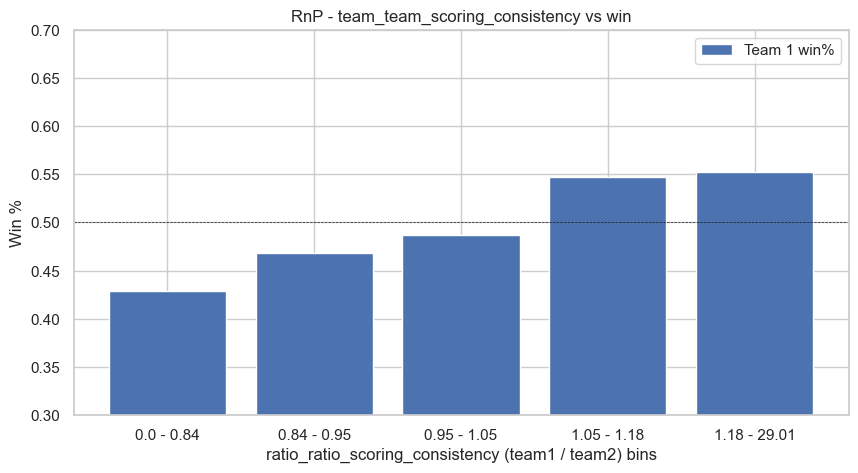

Correlation between team_team_scoring_consistency and winner_01 is: -0.033233741391659126


In [168]:
createRnP(train_data, 'team_team_scoring_consistency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


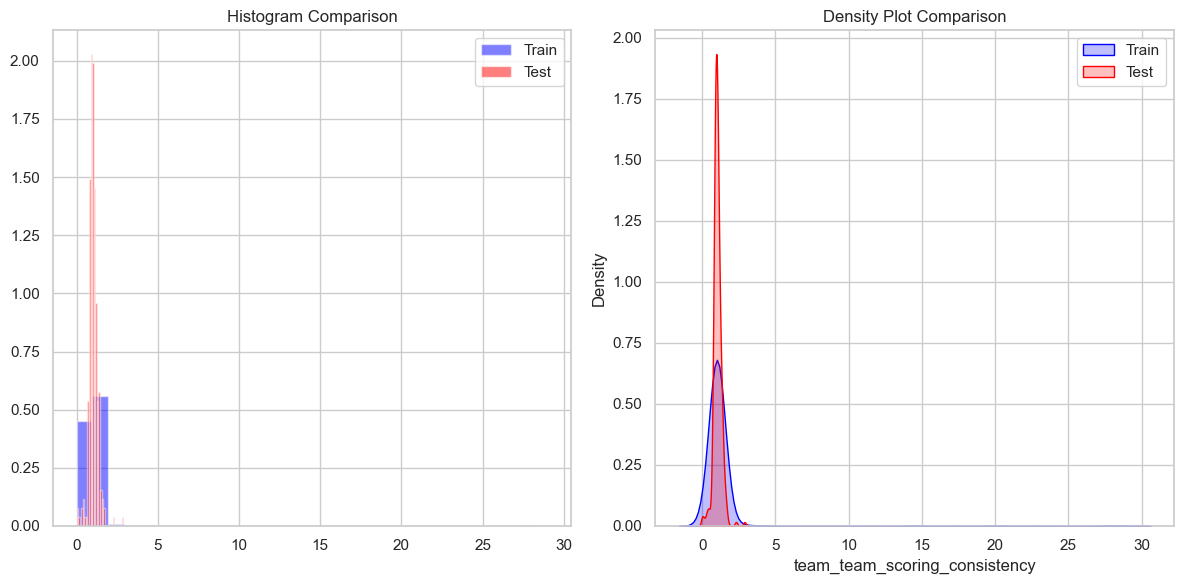

Kolmogorov-Smirnov test result: KS statistic = 0.0359, p-value = 0.9374

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.210957    1.018603
std       2.082633    0.277409
min       0.000000    0.000000
25%       0.879305    0.876245
50%       1.001085    0.993741
75%       1.136666    1.136663
max      29.012335    2.891366


In [169]:
check_distribution_match(train_data['team_team_scoring_consistency'], test_data['team_team_scoring_consistency'])